# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
import cv2
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('./datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./datasets/Project_data/val.csv').readlines())

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Data Visualizing

In [4]:
# getting frames folder for each class
class_number = 0
cls_dict = {}
for item in train_doc:
    seq_cls = item.strip().split(";")
    if class_number > 4:
        break
    elif int(seq_cls[-1]) == class_number:
        cls_dict[class_number] = seq_cls[:2]
        class_number += 1
cls_dict

{0: ['WIN_20180925_17_33_08_Pro_Left_Swipe_new', 'Left_Swipe_new'],
 1: ['WIN_20180926_16_56_46_Pro_Right_Swipe_new', 'Right_Swipe_new'],
 2: ['WIN_20180926_16_59_12_Pro_Stop_new', 'Stop_new'],
 3: ['WIN_20180925_17_47_06_Pro_Thumbs_Down_new', 'Thumbs_Down_new'],
 4: ['WIN_20180926_17_13_29_Pro_Thumbs_Up_new', 'Thumbs_Up_new']}

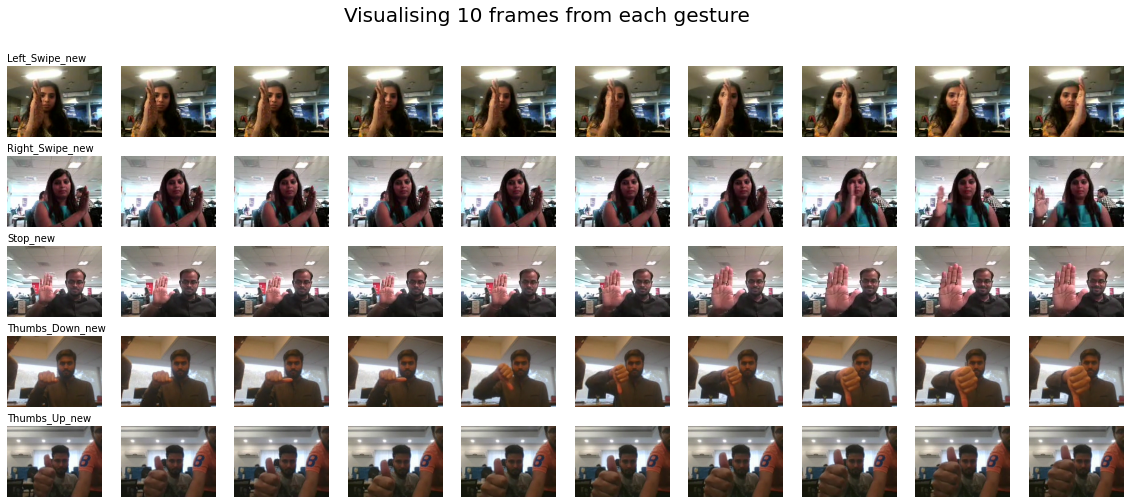

In [5]:
fig, ax = plt.subplots(5, 10, figsize=(20,8))
fig.suptitle('Visualising 10 frames from each gesture', fontsize=20)

train_path = './datasets/Project_data/train'
for idx in range(5):
    img_idx = np.round(np.linspace(0, 29, 10)).astype("int16")
    
    # folder path for each class
    folder_path = train_path + "/" + cls_dict[idx][0]

    # reading the frame of the gesture and showing it
    frames = os.listdir(folder_path)
    
    # setting the title for each sequence of frame of particular class
    ax[idx, 0].set_title(cls_dict[idx][1], loc='left', fontsize=10)
    
    # reading and showing the image
    for i, image_idx in enumerate(img_idx):
        img_path = f"{folder_path}/{frames[image_idx]}"
        ax[idx, i].axis("off")
        ax[idx, i].imshow(plt.imread(img_path))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
class ModelTrainer:
    
    '''
    This class helps to train a model with writing less number of lines of code.
    Each method in this object is defined to make resusuable.
    '''

    def __init__(self, batch_size, epochs, x=30, image_width=120, image_height=120, 
                 lr=0.001, ablation=None, **kwargs):
        self.batch_size = batch_size
        self.ablation = ablation
        self.epochs = epochs
        self.x = x
        self.image_width = image_width
        self.image_height = image_height
        self.reduce_lr = kwargs.get("reduce_lr")
        self.learning_rate = lr
        self.save_checkpoint = kwargs.get("save_checkpoint")
        self.train_path = './datasets/Project_data/train'
        self.val_path = './datasets/Project_data/val'
        self.train_doc = np.random.permutation(open('./datasets/Project_data/train.csv').readlines())[:self.ablation]
        self.val_doc = np.random.permutation(open('./datasets/Project_data/val.csv').readlines())[:self.ablation]
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        print('batch size =', self.batch_size, '; epochs =', self.epochs)

    def data_generator(self, source_path, folder_list, batch_size, x=30):
        
        '''
        This is a generator method which generates batches of data and reshuffling is also dones for every epoch.
        '''

        #create a list of image numbers you want to use for a particular video

        img_idx = np.round(np.linspace(0, 29, self.x)).astype("int16")

        while True:
            t = np.random.permutation(folder_list)

            # calculate the number of batches
            num_batches = len(folder_list)//batch_size

            #iterating over the number of batches
            for batch in range(num_batches): 
                
                batch_data, batch_labels = self.each_batch_data(source_path, t, batch, batch_size, img_idx)
                
                yield  batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            
            # code for the remaining data points which are left after full batches
            remaining = len(folder_list) % batch_size

            if remaining:
                batch_data, batch_labels = self.each_batch_data(source_path, t, num_batches, batch_size, img_idx, 
                                                                remaining=remaining)
                yield batch_data, batch_labels
    
    def each_batch_data(self, source_path, t, batch, batch_size, img_idx, remaining=0):
        
        '''
        This method creates each batch of data.
        '''
        
        batch_size = remaining if remaining else batch_size

        # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_data = np.zeros((batch_size, len(img_idx), self.image_height, self.image_width, 3))

        # batch_labels is the one hot representation of the output 
        batch_labels = np.zeros((batch_size, 5)) 
        
        for folder in range(batch_size): 

            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 

            for idx,item in enumerate(img_idx):

                # reading the image
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                # cropping
                if image.shape[0] != image.shape[1]:
                    image = image[0:120, 20:140]

                # resizing the image
                image = resize(image, (self.image_height, self.image_width))
                
                batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                batch_data[folder,idx,:,:,2] = image[:,:,2]/255
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        return batch_data, batch_labels

    def model_fit(self, model):
        train_generator = self.data_generator(self.train_path, self.train_doc, self.batch_size)
        val_generator = self.data_generator(self.val_path, self.val_doc, self.batch_size)

        callbacks_list = []
        
        if self.reduce_lr:
            callbacks_list.append(self.__reduce_lr_on_plateau())
        if self.save_checkpoint:
            callbacks_list.append(self.__model_checkpoint())

        steps_per_epoch, validation_steps = self.__train_val_steps()

        training = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs,
                  verbose=1, callbacks=callbacks_list, validation_data=val_generator,
                  validation_steps=validation_steps, class_weight=None, workers=1,
                  initial_epoch=0)
        self.__plot_train_val_trade_off(training)
        return training


    def __model_checkpoint(self):
        '''
        It saves the trained model which could be activated by passing
        save_checkpoint=True in model instantiation.
        '''
        
        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init' + '_' + curr_dt_time.strftime("%Y_%m_%d_%H_%M") + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
                
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

        return checkpoint

    def __reduce_lr_on_plateau(self):
        # reduce learning rate if the training plateaus
        lr = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.2, patience=4)
        return lr

    def __train_val_steps(self):
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        return steps_per_epoch, validation_steps

    def __plot_train_val_trade_off(self, history):

        # getting the accuarcies of train and validation dataset after training the model
        acc = history.history['categorical_accuracy']
        val_acc = history.history['val_categorical_accuracy']

        # getting the losses of train and validation dataset after training the model
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(self.epochs)

        plt.figure(figsize=(12, 6))

        # Visualizing the training and validation accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        # Visualizing the training and validatiion loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

    def model_architecture(self):
        pass


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

__Tried to train the model with batch size 64, image width 160 and image height 160 but got ResourceExhaustedError so, used lower batch size for the same. And after few trials we found that image size has more impact on training time than the batch size. Thus, taking the standard batch size of 32 and image size of 120x120 or less would be good enough. However, we will do changes accordingly while training.__

## Conv3D Models

### Model 1

We tried few model architectures randomly and found the below model architecture with which is performing better than models we tried earlier with reduced data. At first, we are trying to overfit the model with less amount of data.

In [8]:

class Model1Conv3D(ModelTrainer):

    def model_architecture(self):

        model = Sequential()

        model.add(Conv3D(8, kernel_size=3, 
                         padding="same",
                         activation="relu",
                         kernel_initializer="he_uniform",
                         input_shape=(self.x, self.image_height, self.image_width, 3)))
        model.add(MaxPooling3D(pool_size=2))

        model.add(Conv3D(16, kernel_size=3, padding="same", activation="relu",))
        model.add(MaxPooling3D(pool_size=2))

        model.add(Conv3D(32, kernel_size=3, padding="same", activation="relu"))
        model.add(MaxPooling3D(pool_size=2))

        model.add(Conv3D(64, kernel_size=3, padding="same", activation="relu"))
        model.add(MaxPooling3D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(Dense(5, activation="softmax"))

        optimiser = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model


batch size = 32 ; epochs = 20
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 8)   656       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 32)     13856     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 15, 15, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)         

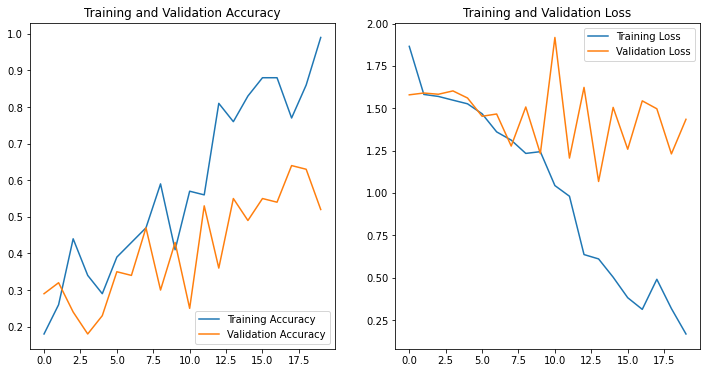

In [9]:
model_trainer = Model1Conv3D(batch_size=32, epochs=20, image_width=120, image_height=120, 
                      ablation=100, reduce_lr=True)
history = model_trainer.model_fit(model_trainer.model_architecture())

We tried to overfit with less amount of data and some what achieved the same.

### Model 2

Now imporving the previous model by adding dropouts and changing the learning rate of optimizer to 0.0001 from 0.001

In [10]:
class Model2Conv3D(ModelTrainer):

    def model_architecture(self):

        model = Sequential()

        model.add(Conv3D(8, kernel_size=(3, 3, 3), 
                         padding="same",
                         input_shape=(self.x, self.image_height, self.image_width, 3)))
        model.add(Activation("relu"))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.1))

        model.add(Conv3D(16, kernel_size=(3, 3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.1))

        model.add(Conv3D(32, kernel_size=(3, 3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv3D(64, kernel_size=(3, 3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(Dropout(0.4))
        model.add(Dense(5, activation="softmax"))

        optimiser = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

batch size = 32 ; epochs = 20
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 16)    0         
_________________________________________________________________
max_pooling3d_5 (MaxPool

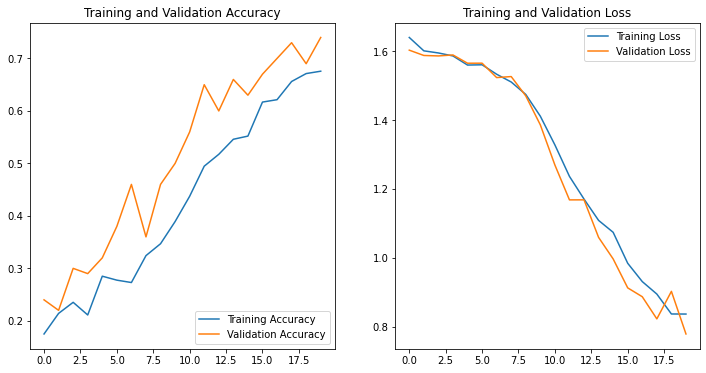

In [11]:
# instantiating and fitting the model
model_trainer = Model2Conv3D(batch_size=32, epochs=20, image_width=120, image_height=120, 
                      reduce_lr=True, lr=0.0001)
history = model_trainer.model_fit(model_trainer.model_architecture())

The above plot shows that the loss will converge more, thus increasing the number of epochs from 20 to 50.

batch size = 32 ; epochs = 50
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 16)    0         
_________________________________________________________________
max_pooling3d_9 (MaxPool

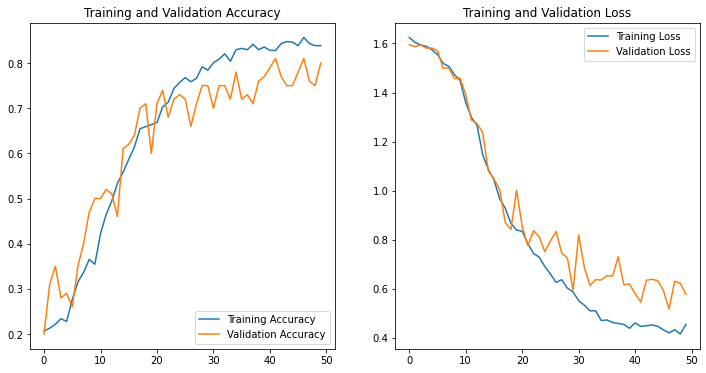

In [12]:
# instantiating and fitting the model
model_trainer = Model2Conv3D(batch_size=32, epochs=50, image_width=120, image_height=120, 
                      reduce_lr=True, lr=0.0001)
history = model_trainer.model_fit(model_trainer.model_architecture())

### Model 3

Trying with different model architecture in a hope to get model accuracy than the previous one.

In [13]:
# defining the model architecture
class Model3Conv3D(ModelTrainer):

    def model_architecture(self):

        model = Sequential()

        model.add(Conv3D(16, kernel_size=(3, 3, 3), 
                         padding="same",
                         input_shape=(self.x, self.image_height, self.image_width, 3)))
        model.add(Activation("relu"))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, kernel_size=(3, 3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.1))

        model.add(Conv3D(64, kernel_size=(3, 3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.1))

        model.add(Conv3D(128, kernel_size=(3, 3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dense(256, activation="relu"))
        model.add(Dropout(0.3))
        model.add(Dense(5, activation="softmax"))

        optimiser = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

batch size = 32 ; epochs = 20
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 15, 50, 50, 32)    0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 25, 25, 32)     0         
_________________________________________________________________
dropout_10 (Dropout)    

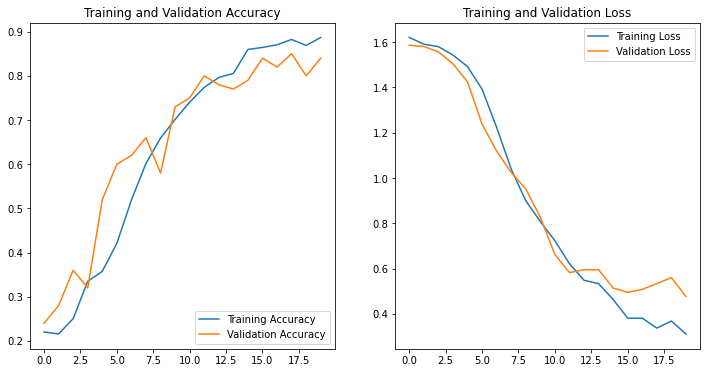

In [14]:
# instantiating and fitting the model
model_trainer = Model3Conv3D(batch_size=32, epochs=20, image_width=100, image_height=100, 
                      reduce_lr=True, lr=0.0001)
history = model_trainer.model_fit(model_trainer.model_architecture())

## CNN2D + RNN

Till now we train on 3D Convoltion model architecture. As mentioned, from here on we will use 2D Convolution with Recurrent Neural Network to fit the model and will see whether this is generalizing well on the data than 3D Convolutions.

### Model 5

In [15]:
# defining the 1st CNN + RNN model
class Model1RNN(ModelTrainer):

    def model_architecture(self):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding="same", activation="relu"),
                                  input_shape=(self.x, self.image_height, self.image_width, 3)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu")))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding="same", activation="relu")))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(128))
        model.add(Dropout(0.2))
        
        model.add(Dense(128,activation="relu"))
        model.add(Dropout(0.4))

        model.add(Dense(5, activation="softmax"))

        optimiser = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

batch size = 32 ; epochs = 20
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_6 (Time

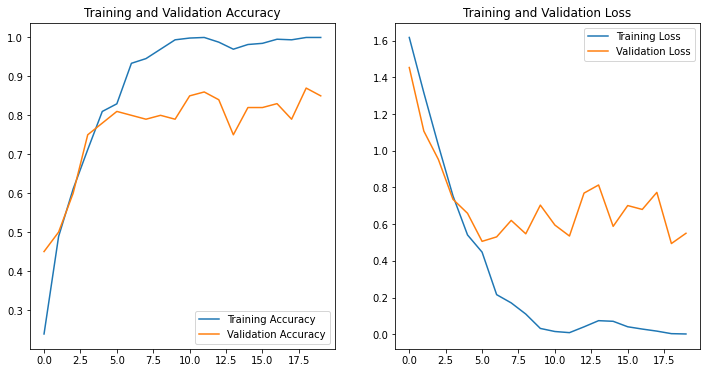

In [17]:
# instantiating and fitting the model 
model_trainer = Model1RNN(batch_size=32, epochs=20, image_width=120, image_height=120)
history = model_trainer.model_fit(model_trainer.model_architecture())

### Model 6 (Resnet - Transfer Learning)

We have seen earlier that manually defining the 2D-CNN with RNN is not generalizing well on the data. So, we can use pretrained 2D convolution for extraction of features of frames which would be done in every timestep. Here we are using Resnet50 pretrained model.

In [23]:
# defining the 2nd CNN + RNN model
class Model2RNN(ModelTrainer):

    def model_architecture(self):

        resnet = ResNet50(include_top=False,
                          weights="imagenet")
        
        # making the top 40 layers non trainable
        for layer in resnet.layers[:40]:
            layer.trainable = False

        model = Sequential()

        model.add(TimeDistributed(resnet, input_shape=(self.x, self.image_height,self.image_width,3)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(16))

        model.add(Dense(16, activation="relu"))
        model.add(Dropout(0.3))

        model.add(Dense(5, activation="softmax"))

        optimiser = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model


batch size = 16 ; epochs = 20
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 30, 3, 3, 2048)    23587712  
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 1, 1, 2048)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 2048)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                132160    
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)        

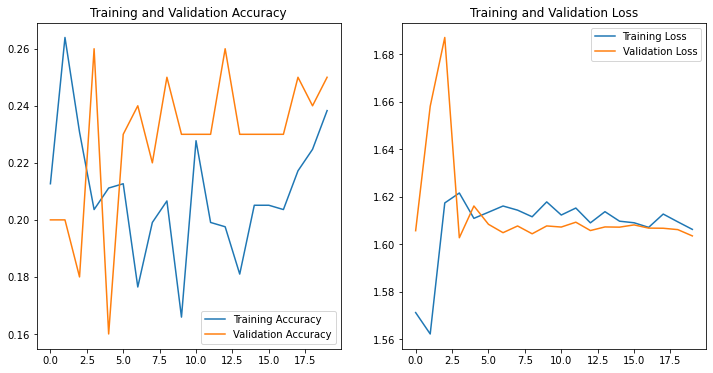

In [25]:
model_trainer = Model2RNN(batch_size=16, epochs=20, image_width=80, image_height=80, reduce_lr=True)
history = model_trainer.model_fit(model_trainer.model_architecture())

### Model 7 (Mobilenet - Transfer Learning)

Only training parameters of last 10 layers

In [26]:
class Model3RNN(ModelTrainer):

    def model_architecture(self):

        mobilenet = MobileNet(include_top=False, weights="imagenet")

        # making some layers trainable
        for layer in mobilenet.layers[:-10]:
            layer.trainable = False

        model = Sequential()

        model.add(TimeDistributed(mobilenet, input_shape=(self.x, self.image_height,self.image_width,3)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(128))
        model.add(Dropout(0.3))

        model.add(Dense(128, activation="relu"))
        model.add(Dropout(0.5))

        model.add(Dense(5, activation="softmax"))

        optimiser = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

batch size = 13 ; epochs = 20
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_22 (Dropout)   

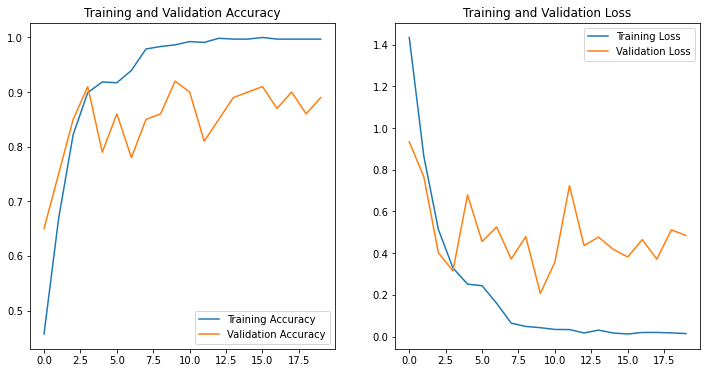

In [27]:
model_trainer = Model3RNN(batch_size=13, epochs=20, image_width=120, image_height=120, reduce_lr=True)
history = model_trainer.model_fit(model_trainer.model_architecture())

The plot shows that it's not performing well on the data.

### Model 8 (Mobilenet - Transfer Learning)

Apart from Resnet we could using Mobilenet is another architecture which we could user for 2D Convolution.
Increasing number of epochs, reduced learning rate and removing the dropout after GRU layer. And training all the parameters of Mobilenet architecture.

In [28]:
# definging the model
class Model4RNN(ModelTrainer):

    def model_architecture(self):

        mobilenet = MobileNet(include_top=False, weights="imagenet")

        model = Sequential()

        model.add(TimeDistributed(mobilenet, input_shape=(self.x, self.image_height,self.image_width,3)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(128))
        model.add(Dropout(0.2))

        model.add(Dense(128, activation="relu"))
        model.add(Dropout(0.4))

        model.add(Dense(5, activation="softmax"))

        optimiser = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

batch size = 5 ; epochs = 20
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_25 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_26 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_24 (Dropout)    

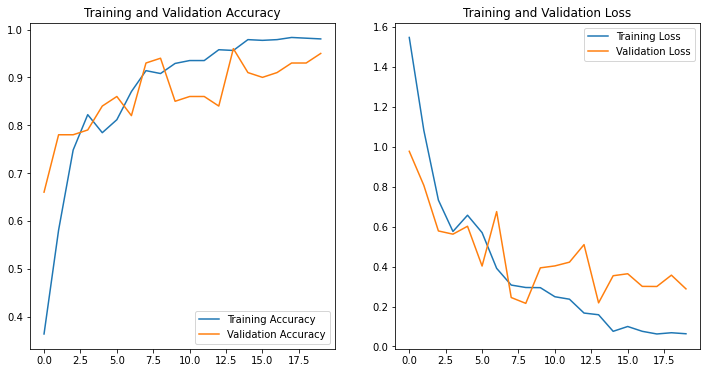

In [29]:
# instantiating and fitting the model
model_trainer = Model3RNN(batch_size=5, epochs=20, image_width=120, image_height=120, reduce_lr=True)
history = model_trainer.model_fit(model_trainer.model_architecture())

### Model 9

In previous model we can add BatchNormalisation and did some slight tweaks to in dropouts.

In [30]:
class Model2RNN(ModelTrainer):

    def model_architecture(self):

        mobilenet = MobileNet(include_top=False, weights="imagenet")

        # making some layers trainable
        # for layer in mobilenet.layers[:-10]:
        #     layer.trainable = False

        model = Sequential()

        model.add(TimeDistributed(mobilenet, input_shape=(self.x, self.image_height,self.image_width,3)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(128))
        model.add(Dropout(0.2))

        model.add(Dense(128, activation="relu"))
        model.add(Dropout(0.3))

        model.add(Dense(5, activation="softmax"))

        optimiser = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

In [ ]:
model_trainer = Model2RNN(batch_size=5, epochs=20, x=20, image_width=120, image_height=120, lr=0.0009, 
                          reduce_lr=True)
history = model_trainer.model_fit(model_trainer.model_architecture())

batch size = 5 ; epochs = 20
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_29 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)        